# Project Description

The aim of this project is to identify patterns that determine whether a game succeeds or not which will allow in spotting potential big winners and plan advertising campaigns.<br>
Here we will be investigating user and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources for the online store Ice, which sells video games all over the world. 
We have data which is going back to 2016 for planning a campaign for 2017.<br>
The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.<br>


Data description<br>
- Name
- Platform
- Year_of_Release
- Genre
- NA_sales (North American sales in USD million)
- EU_sales (sales in Europe in USD million)
- JP_sales (sales in Japan in USD million)
- Other_sales (sales in other countries in USD million)
- Critic_Score (maximum of 100)
- User_Score (maximum of 10)
- Rating (ESRB)

<br>Data for 2016 may be incomplete.

## Open the data file and study the general information

In [1]:
#importing libraries

from matplotlib import pyplot
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from functools import reduce
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Loading the file into game_info dataframe
game_info = pd.read_csv('/datasets/games.csv')

#Studying the general information 
print('\n\nGames')
print(game_info.describe())
print(game_info.head())
print('\n Number of duplicated rows in game_info dataframe:',game_info.duplicated().sum())
print()
print(game_info.info())
print('\n\nSkewness:')
print(game_info.skew())
game_info.isnull().sum()*100/len(game_info)




Games
       Year_of_Release      NA_sales      EU_sales      JP_sales  \
count     16446.000000  16715.000000  16715.000000  16715.000000   
mean       2006.484616      0.263377      0.145060      0.077617   
std           5.877050      0.813604      0.503339      0.308853   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2016.000000     41.360000     28.960000     10.220000   

        Other_sales  Critic_Score  
count  16715.000000   8137.000000  
mean       0.047342     68.967679  
std        0.186731     13.938165  
min        0.000000     13.000000  
25%        0.000000     60.000000  
50%        0.010000     71.000000  
75%        0.030000     79.000000  
max       10.570000     98.000000  
                       Name Platform  Year_of_Release  

Name                0.011965
Platform            0.000000
Year_of_Release     1.609333
Genre               0.011965
NA_sales            0.000000
EU_sales            0.000000
JP_sales            0.000000
Other_sales         0.000000
Critic_Score       51.319174
User_Score         40.089740
Rating             40.478612
dtype: float64

#### Conclusion

- The date column has a wrong datatype.
- The column names have upper case, would be changing them
- There are missing values in several columns - `critic_score`,`user_score`,`name`,`year_of_release`,`genre` and `rating`.
- There are no duplicated rows in the dataframe
- We can also see that the data is highly skewed.


## Prepare the Data

### Replace the column names (make them lowercase)

In [3]:
#Changing the column names to lower case
game_info.columns = map(str.lower, game_info.columns)

#### Conclusion

- The column names have upper case so changed them to smaller case for better readability and accessibility

### Convert the data to the required types.

In [4]:
#Changing the datatype of all the dates of all the dataframes into datetime
game_info['year_of_release'] = pd.to_datetime(game_info['year_of_release'] , format='%Y')
#just adding the year back to the column for ease of calculations
game_info['year_of_release'] = pd.DatetimeIndex(game_info['year_of_release']).year




#### Conclusion

- Converted the datatype of year_of release to datetime from string and then just added the year back with datetime.year method for ease of calculations.


### Dealing with missing values:

In [5]:
#Working on missing values
#Name column has only two missing values, dropping both of those rows,  which are eventually the same genre null rows
game_info = game_info.dropna(subset=['name'])


#Filling year_of_release missing values
game_info['year_of_release']= game_info.groupby(['name'], sort=False)['year_of_release'].apply(lambda x: x.fillna(x.mode()))
game_info = game_info.dropna(subset=['year_of_release'])


#Filling user_score by grouping `name`,`genre` and `platform` columns
#first replacing the tbd values with null values\n",
game_info['user_score'] = game_info['user_score'].replace('tbd',np.NaN)


#Filling rating by grouping with undefined value
game_info['rating'] = game_info['rating'].fillna(value = 'undefined')


#### Conclusion

- Initially there were missing values in `name`,`year_of release`,`critic_score`,`user_score` and `rating` columns
- Removed the two rows that had missing values in the `name` column
- Filled the missing values of `year_of release` with the mode value which we got by grouping `name` column as mostly games are rated based on the name. Remaining 269 null valued rows we have dropped it as it was only 1.6% of the data.
- Similarily filled the missing values of `rating` column with the NaN values 
- The missing values in the `user_score` column there are several missing values out of which most of them are 'tbd' values , but there is not much information to determine these values so I just replaced these values with null values so that it doesn't come in our way during the analysis.
- The reason we did not fill the null values is because we can't guarantee we would do it right, too much missing values, so when analyzing - we will just use the subset of the data without any missing values

### Calculate the total sales (the sum of sales in all regions) for each game and put these values in a separate column.

In [6]:

#Calculating the total_sales
game_info['total_sales'] = game_info.na_sales + game_info.eu_sales + game_info.jp_sales + game_info.other_sales

#Checking for the updated datatype and names
print('\n\nGames')
game_info.info()



Games
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null object
rating             16444 non-null object
total_sales        16444 non-null float64
dtypes: float64(7), object(5)
memory usage: 1.6+ MB


#### Conclusion

- Added a `total_sales` column to the dataframe which contains the sum of sales of NA,EU,Japan and other regions for each respective game

## Analyze the data

We are going to analyze the games data to look how many different games were released each year , how sales varied from platform to platform, determine what period you should take data for, look for  potentially profitable platforms, find  average sales on various platforms, calculate the correlation between reviews and sales, investigate general distribution of games by genre.

### Look at how many games were released in different years.

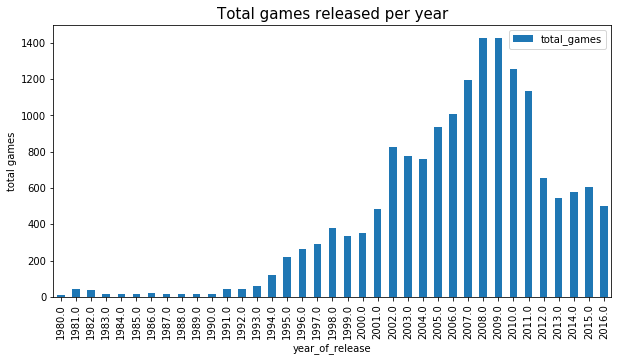

In [25]:

#calculating total games per year
total_games_year = game_info.groupby('year_of_release')['name'].agg({'total_games':'count'})

total_games_plot = total_games_year['total_games'].plot.bar(figsize=(10,5))
total_games_plot.set_title('Total games released per year',fontsize=(15))
total_games_plot.set_ylabel('total games')
total_games_plot.legend();
pyplot.show()




#### Conclusion

- We see a increase in the number of games mainly from 2000, 2008 and 2009 did really well in terms of number of games released but we also see a steady decrease after 2012
- There is a boom in the number of games released per year from 1995, after which there is an higher growth rate from 2005. But then again it started decreasing from 2010.


### Look at how sales varied from platform to platform. 

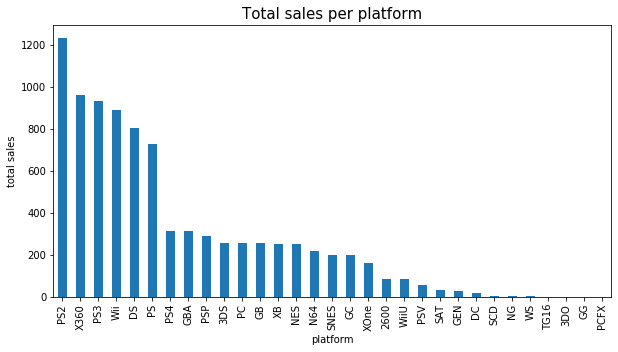

          total_sales
platform             
PS2           1233.56
X360           961.24
PS3            931.34
Wii            891.18
DS             802.78


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
2,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
3,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
4,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


In [35]:
#Finding out total sales per platform and plotting a bar graph
total_sales_platform = game_info.groupby('platform')['total_sales'].agg({'total_sales':'sum'})
total_sales_platform.sort_values(by='total_sales',ascending=False,inplace=True)
total_sales_plot = total_sales_platform['total_sales'].plot.bar(figsize=(10,5))
total_sales_plot.set_title('Total sales per platform',fontsize=(15))
total_sales_plot.set_ylabel('total sales')
pyplot.show()

#Selecting platforms with highest number of sales
print(total_sales_platform.head())

#Selecting the data of platforms with highest sales
platform_sales = game_info.query('platform == ["DS","PS2","PS3","Wii","X360"]')
platform_sales = platform_sales.reset_index(drop=True)

platform_sales.head()


#### Conclusion

- PS2,X360,PS3,Wii,DS,PS are the platforms which have high number of sales

### Determine what period you should take data for. To do so, look at your answers to the previous questions. The data should allow you to build a prognosis for 2017.

Games data after the year 2013
                                         name platform  year_of_release  \
31                  Call of Duty: Black Ops 3      PS4           2015.0   
42                         Grand Theft Auto V      PS4           2014.0   
47  Pokemon Omega Ruby/Pokemon Alpha Sapphire      3DS           2014.0   
77                                    FIFA 16      PS4           2015.0   
87               Star Wars Battlefront (2015)      PS4           2015.0   

           genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
31       Shooter      6.03      5.86      0.36         2.38           NaN   
42        Action      3.96      6.31      0.38         1.97          97.0   
47  Role-Playing      4.35      3.49      3.10         0.74           NaN   
77        Sports      1.12      6.12      0.06         1.28          82.0   
87       Shooter      2.99      3.49      0.22         1.28           NaN   

   user_score     rating  total_sales  
31        NaN  

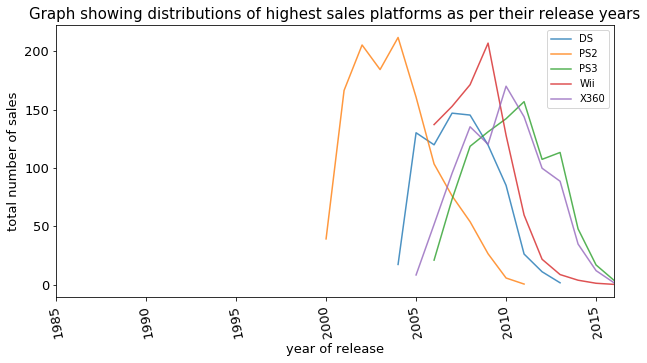

In [29]:

#Based on the 10 year lifetime,selecting data after 2013 for 2017 prognosis
print('Games data after the year 2013')
games = game_info[game_info['year_of_release'] > 2013]
print(games.head())


#Changing the user_score to int datatype
games['user_score'] =  games['user_score'].astype('float')


#calculating total sales for each platform per year
platform_sales_year = platform_sales.groupby(['platform','year_of_release'])['total_sales'].agg({'total_sales':'sum'})
platform_sales_year = platform_sales_year.reset_index()


#Analysing the timeline required for 2017 prognosis by finding distributions of platform sales based on year of release\n",
platform_sales_yearpivot = platform_sales_year.pivot_table(index='year_of_release',columns='platform',values='total_sales')
platform_sales_yearplot = platform_sales_yearpivot.plot(kind = 'line',rot=100,figsize=(10,5),fontsize=13, alpha = 0.8)
platform_sales_yearplot.set_title('Graph showing distributions of highest sales platforms as per their release years',fontsize=15)
platform_sales_yearplot.set_xlabel('year of release',fontsize=13)
platform_sales_yearplot.legend()
platform_sales_yearplot.set_ylabel('total number of sales',fontsize=13)
pyplot.show()





#### Conclusion

- PS2: We see that the leader in sales in the entire history of the PS2. But sales by 2011 are already equal to zero. Or X360: it was at its peak in 2010, but by 2016 it had dropped to almost 0. 
- From the above line graph it's clearly evident that the platforms that were once most popular ones don't have sales in 2016 at all  such as PS2,DS
- However, there are very few sales for about less than 5 million USD for the PS3,Wii and X360 platforms.
- By looking at the graph we can say that usually the platforms are in the market for around 10 years
- Based on the above findings , we can say that data after the year 2013 would be perfect for our analysis. The relevance of the game falls according to the charts on average for 3-4 years (since games quickly become obsolete, although they can continue to be sold in stores) Accordingly, if we choose a longer period,we risk capturing a lagging trend, i.e. we include in the data irrelevant pre-period platforms that should not remain in the data for the predicted period.
- We have formed a new dataframe `games` with the data after the year 2013

### Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms.


Total sales per platform


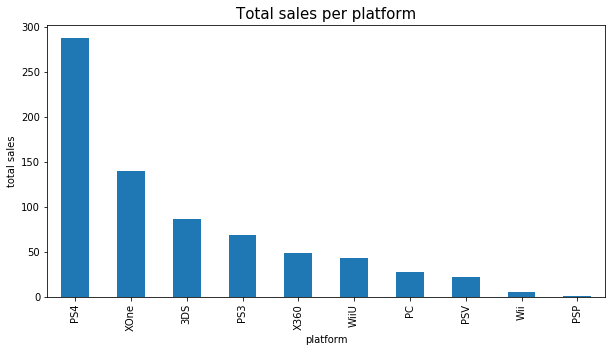


 Growing platforms:
          total_sales
platform             
PS4            288.15
XOne           140.36
3DS             86.68
PS3             68.18
X360            48.22

 Sinking platforms:
          total_sales
platform             
WiiU            42.98
PC              27.05
PSV             22.40
Wii              5.07
PSP              0.36


In [36]:

#Finding platforms that are leading and lagging in sales  and also plotting a bar graph
new_platform_sales = games.groupby('platform')['total_sales'].agg({'total_sales':'sum'})
new_platform_sales.sort_values(by='total_sales',ascending=False,inplace=True)
print('\nTotal sales per platform')
#print(new_platform_sales.head())
new_platform_salesplot = new_platform_sales['total_sales'].plot.bar(figsize=(10,5))
new_platform_salesplot.set_title('Total sales per platform',fontsize=(15))
new_platform_salesplot.set_ylabel('total sales')
pyplot.show()

print('\n Growing platforms:')
print(new_platform_sales.head(5))
print('\n Sinking platforms:')
print(new_platform_sales.tail(5))



#### Conclusion

- We can now see which platforms turns in more sales. PS4,Xone,3DS,PS3 and X360 are leading in sales.

### Build a box plot for the global sales of all games, broken down by platform. 

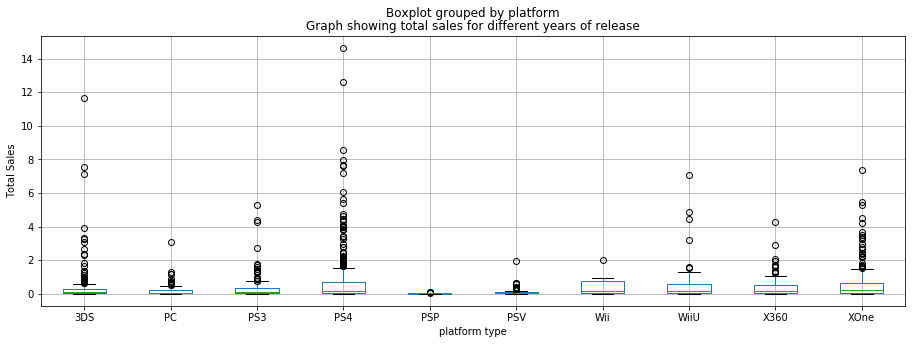

Average of the sales of each platform:
          total_sales
platform             
3DS          0.408868
PC           0.179139
PS3          0.311324
PS4          0.766356
PSP          0.027692
PSV          0.075932
Wii          0.460909
WiiU         0.588767
X360         0.434414
XOne         0.615614


In [10]:

#Build a box plot for the global sales of all games, broken down by platform.
games.boxplot(column = ['total_sales'], by = 'platform' ,figsize = (15,5)).set(title='Graph showing total sales for different years of release', xlabel='platform type', ylabel='Total Sales')
pyplot.show()
plat_sales = games.pivot_table(index='platform',values='total_sales')
print('Average of the sales of each platform:')
print(plat_sales)


#### Conclusion

- From the above boxplot we can see the amount of  difference in the global sales of these platforms, here the total sales vary from almost 1 million USD to 36 million USD


### Build a scatter plot and calculate the correlation between reviews and sales for one popular platform (PS4)

Correlation between sales of PS4 and critic score is 0.40266141068104083
Correlation between sales of PS4 and user score is -0.040131589472697356


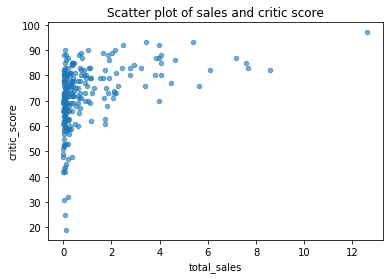

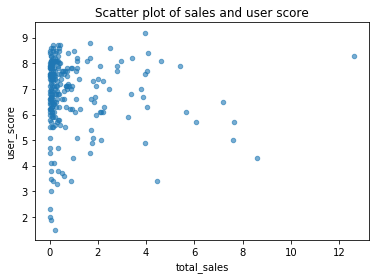

In [51]:
#selecting PS4 data 
ps4_data = games.query("platform =='PS4'")
ps4_data.isna().sum()


# plotting scatter plot for critic score and user score and sales of PS4 platform
scatter_graphc = ps4_data.plot(x='total_sales',y='critic_score',kind='scatter',alpha = 0.6) 
scatter_graphc.set_title('Scatter plot of sales and critic score' )
scatter_graphu = ps4_data.plot(x='total_sales',y='user_score',kind='scatter',alpha = 0.6) 
scatter_graphu.set_title('Scatter plot of sales and user score' )


#Finding the correlation between critic score and user score and sales of PS4 platform
print('Correlation between sales of PS4 and critic score is', (ps4_data['total_sales']).corr(ps4_data['critic_score']))
print('Correlation between sales of PS4 and user score is', (ps4_data['total_sales']).corr(ps4_data['user_score']))


#### Conclusion


- Here we can see that the correlation between critic score and sales is approximately 0.4 which indicates that as the critic score increases the number of sales also increases. 
- Also we  see that the correlation between user score and sales is approximately -0.166 which indicates that there is a low dependency between the user score and the number of sales  .
- Both the Scatter plot graphs also confirm the same


### Compare the sales of the same games on other platforms.

Correlation between sales of PS4 and critic score is 0.28652300431660405
Correlation between sales of PS4 and user score is -0.14040603058285647


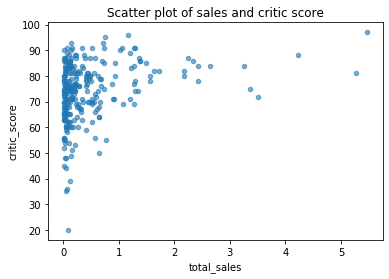

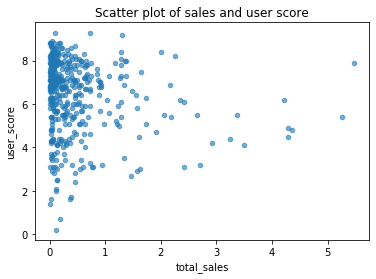

In [54]:
# comparing the sales of the same games of PS4 platform on other platforms

nonps4_sales = games[games.name.isin(ps4_data.name)]
nonps4_sales = nonps4_sales[nonps4_sales.platform != 'PS4']

# plotting scatter plot for critic score and user score and sales of non PS4 platform
scatter_graphc_nonps4 = nonps4_sales.plot(x='total_sales',y='critic_score',kind='scatter',alpha = 0.6) 
scatter_graphc_nonps4.set_title('Scatter plot of sales and critic score' )
scatter_graphu_nonps4 = nonps4_sales.plot(x='total_sales',y='user_score',kind='scatter',alpha = 0.6) 
scatter_graphu_nonps4.set_title('Scatter plot of sales and user score' )


#Finding the correlation between critic score and user score and sales of non PS4 platform
print('Correlation between sales of PS4 and critic score is', (nonps4_sales['total_sales']).corr(nonps4_sales['critic_score']))
print('Correlation between sales of PS4 and user score is', (nonps4_sales['total_sales']).corr(nonps4_sales['user_score']))

#### Conclusion



- Here we can see that the correlation between critic score and sales is approximately 0.3 which indicates that as the critic score increases the number of sales also increases. 
- Also we  see that the correlation between user score and sales is approximately -0.140 which indicates that there is a low dependency between the user score and the number of sales  .
- Both the Scatter plot graphs also confirm the same, it follows the same pattern of PS4 platform but just the intensity is different
- We might conclude that games performance depends on the platform. 



### Take a look at the general distribution of games by genre. 

In [59]:
#calculating total number of sales and games for each genre
genre_sales = games.pivot_table(index='genre',values=['total_sales','name'],aggfunc={'total_sales':'sum','name':'count'})
genre_sales.sort_values(by=['name','total_sales'],ascending=False,inplace=True)
genre_sales.rename(columns={'name':'total_games'},inplace=True)
genre_sales['ratio'] = genre_sales['total_sales'] / genre_sales['total_games']
print(genre_sales.sort_values('ratio', ascending = False))



              total_games  total_sales     ratio
genre                                           
Shooter               128       170.94  1.335469
Sports                161       109.48  0.680000
Platform               38        18.09  0.476053
Fighting               60        28.22  0.470333
Role-Playing          221       101.44  0.459005
Racing                 69        27.52  0.398841
Misc                  113        37.55  0.332301
Action                619       199.36  0.322068
Simulation             44        13.13  0.298409
Puzzle                 14         2.21  0.157857
Strategy               37         3.96  0.107027
Adventure             185        17.55  0.094865


#### Conclusion

- When we compare the global sales and genre we need to take into consideration the total number of games as well! Because we can see that second highest number of games are for Action genre but the sales is not proportionate compared to other genres
- Shooter games perform the best in terms of sales to number of games ratio

### Choose the platforms with the greatest total sales and build a distribution based on data for each year. Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?

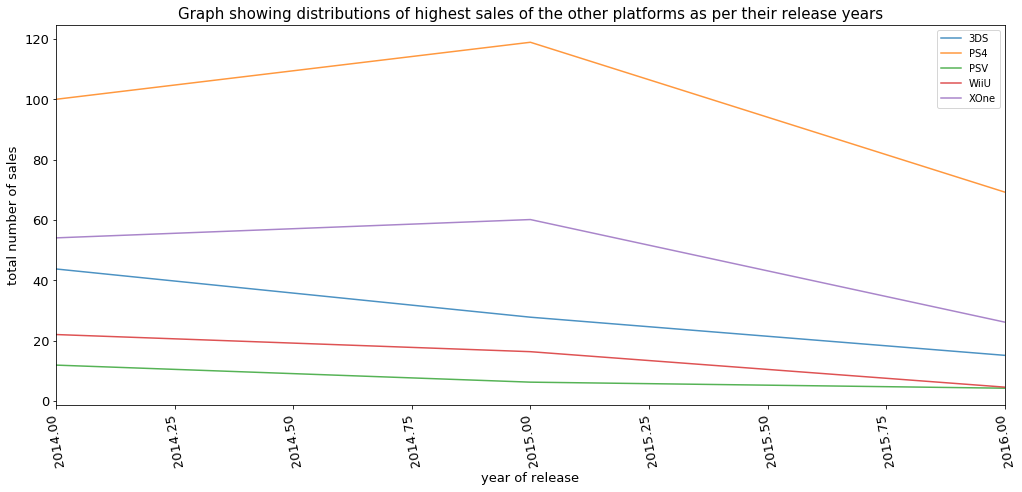

platform           3DS     PS4    PSV   WiiU   XOne
year_of_release                                    
2014.0           43.76  100.00  11.90  22.03  54.07
2015.0           27.78  118.90   6.25  16.35  60.14
2016.0           15.14   69.25   4.25   4.60  26.15


In [56]:
#Selecting the data of platforms with highest sales -  comparing the sales of the same games on other platforms
platform_othersales = games.query('platform == ["3DS","PS4","PSV","WiiU","XOne"]')
platform_othersales = platform_othersales.reset_index()
#platform_sales.drop(columns=['index'])
platform_othersales.head()

#calculating total sales for each platform per year -  compare the sales of the same games on other platforms
platform_othersales_year = platform_othersales.groupby(['platform','year_of_release'])['total_sales'].agg({'total_sales':'sum'})
platform_othersales_year = platform_othersales_year.reset_index()


#finding distributions of other platform sales based on year of release -  compare the sales of the same games on other platforms
platform_othersales_yearpivot = platform_othersales_year.pivot_table(index='year_of_release',columns='platform',values='total_sales')
platform_othersales_yearplot = platform_othersales_yearpivot.plot(kind = 'line',rot=100,figsize=(17,7),fontsize=13, alpha = 0.8)
platform_othersales_yearplot.set_title('Graph showing distributions of highest sales of the other platforms as per their release years',fontsize=15)
platform_othersales_yearplot.set_xlabel('year of release',fontsize=13)
platform_othersales_yearplot.legend()
platform_othersales_yearplot.set_ylabel('total number of sales',fontsize=13)
pyplot.show()
print(platform_othersales_yearpivot)




#### Conclusion


- There is no one conclusion to say about the dependency
- From the above line graph we see that the other platforms the ones apart from the previous anmalysed graphs also show same kind of pattern, i.e they reach to a peak and then they have a gradual fall.

## Create a user profile for each region

### The top five platforms based on their market shares from region to region. For each region (NA, EU, JP)

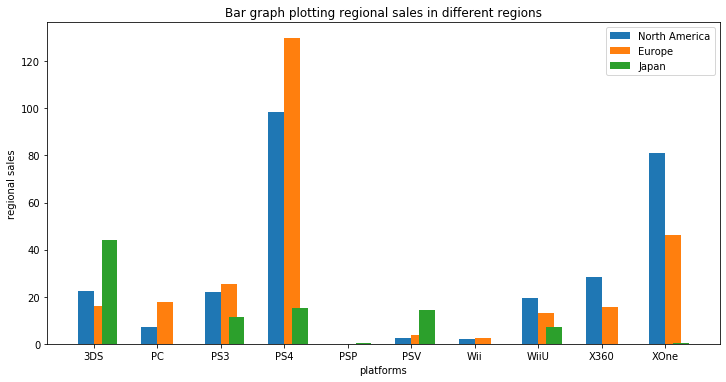

In [16]:
#creating pivot tables for all the three regions to calculate their corresponding regional sales per platform
na_platform = games.pivot_table(index='platform',values='na_sales',aggfunc='sum')
na_platform.reset_index(inplace=True)
eu_platform = games.pivot_table(index='platform',values='eu_sales',aggfunc='sum')
eu_platform.reset_index(inplace=True)
jp_platform = games.pivot_table(index='platform',values='jp_sales',aggfunc='sum')
jp_platform.reset_index(inplace=True)


#plotting a bar graph representing regional sales per platform over different regions
x = np.arange(len(na_platform['platform']))
width=0.25
fig, ax = pyplot.subplots(figsize=(10,5))
r1 = ax.bar(x - width/2, na_platform['na_sales'], width, label='North America')
r2 = ax.bar(x + width/2, eu_platform['eu_sales'], width, label='Europe')
r3 = ax.bar(x + width, jp_platform['jp_sales'], width, label='Japan')
pyplot.legend(loc='upper right')
fig.tight_layout()
ax.set_ylabel('regional sales')
ax.set_xlabel('platforms')
ax.set_title('Bar graph plotting regional sales in different regions')
ax.set_xticks(x)
ax.set_xticklabels(na_platform['platform'])
pyplot.show()

#### Conclusion

- From the above graph we can see that  the following platforms were most profitable in corresponding regions:
1. North America - PS4,XOne,X360,PS3 and 3DS
2. Europe - PS4,XOne,X360,PS3 and PS
3. Japan - 3DS,PS3,PS4,PSV and Wiiu
- We can see that there we very few sales in Japan when compared to other two regions which was followed by Europe, there by making highest sales in North America.
- The most common profitable platforms among all the three regions are 'PS3', 'PS4','3DS'.

### The top five genres.  For each region (NA, EU, JP)

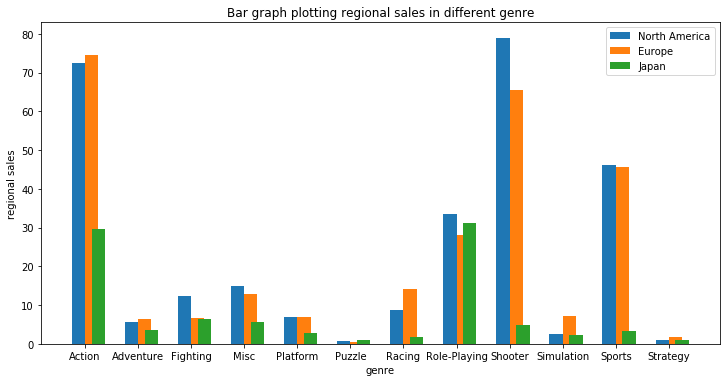

In [17]:
# creating pivot tables for all the three regions to calculate their corresponding regional sales per genre\n",
na_genre = games.pivot_table(index='genre',values='na_sales',aggfunc='sum')
na_genre.reset_index(inplace=True)
eu_genre = games.pivot_table(index='genre',values='eu_sales',aggfunc='sum')
eu_genre.reset_index(inplace=True)
jp_genre = games.pivot_table(index='genre',values='jp_sales',aggfunc='sum')
jp_genre.reset_index(inplace=True)


#plotting a bar graph representing regional sales per genre over different regions
x = np.arange(len(na_genre['genre']))
width=0.25
fig, ax = pyplot.subplots(figsize=(10,5))
r1 = ax.bar(x - width/2, na_genre['na_sales'], width, label='North America')
r2 = ax.bar(x + width/2, eu_genre['eu_sales'], width, label='Europe')
r3 = ax.bar(x + width, jp_genre['jp_sales'], width, label='Japan')
pyplot.legend(loc='upper right')
fig.tight_layout()
ax.set_ylabel('regional sales')
ax.set_xlabel('genre')
ax.set_title('Bar graph plotting regional sales in different genre')
ax.set_xticks(x)
ax.set_xticklabels(na_genre['genre'])
pyplot.show()

#### Conclusion

- The top 5 genre for :
    - NA: Action, Misc,Role Playing,Shooter,Sports
    - Europe: Action,Misc,Racing,Shooter,Sports
    - Japan: Action, Adventure, Fighting, Misc, RolePlaying, Sports
- The difference being same as the Platform- it follows the similar pattern. NA>Europe>Japan

### Do ESRB ratings affect sales in individual regions?  For each region (NA, EU, JP)

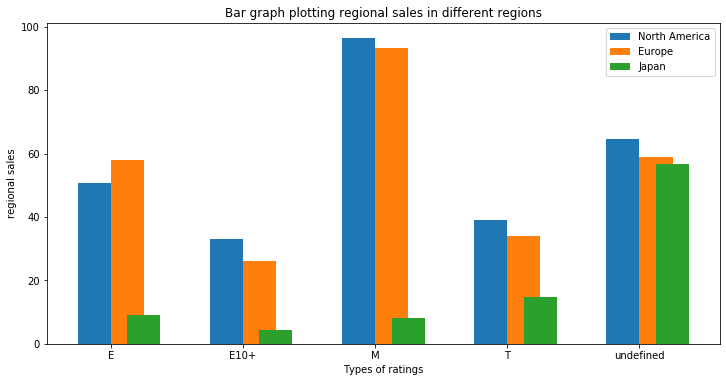

In [18]:
#creating pivot tables for all the three regions to calculate their corresponding regional sales for different ratings
na_rating = games.pivot_table(index='rating',values='na_sales',aggfunc='sum')
na_rating.reset_index(inplace=True)
eu_rating = games.pivot_table(index='rating',values='eu_sales',aggfunc='sum')
eu_rating.reset_index(inplace=True)
jp_rating = games.pivot_table(index='rating',values='jp_sales',aggfunc='sum')
jp_rating.reset_index(inplace=True)

#plotting a bar graph representing regional sales over different regions for different ratings
x = np.arange(len(na_rating['rating']))
width=0.25
fig, ax = pyplot.subplots(figsize=(10,5))
r1 = ax.bar(x - width/2, na_rating['na_sales'], width, label='North America')
r2 = ax.bar(x + width/2, eu_rating['eu_sales'], width, label='Europe')
r3 = ax.bar(x + width, jp_rating['jp_sales'], width, label='Japan')
pyplot.legend(loc='upper right')
fig.tight_layout()
ax.set_ylabel('regional sales')
ax.set_xlabel('Types of ratings')
ax.set_title('Bar graph plotting regional sales in different regions')
ax.set_xticks(x)
ax.set_xticklabels(na_rating['rating'])
pyplot.show()

#### Conclusion

- The top ratings for :
    - NA: M>undefined>E>T>E10+
    - Europe: M>E>undefined>T>E10+
    - Japan: undefined>T>E>M>E10+
- We can here notice that NA and Europe follow kind of similar pattern regarding the ESRB rating whereas Japan there is a higher sale of Teen rated games when excluding the undefined rating of ESRB

## Test the following hypotheses:

### Average user ratings of the Xbox One and PC platforms are the same.


We start with the null hypothesis H₀ : “Average user ratings of the Xbox One and PC platforms are the same.” The alternative hypothesis, H₁, is based on H₀. For this H₀, H₁ would be, “Average user ratings of the Xbox One and PC platforms are not same.”

In [19]:
games['user_score'] = games['user_score'].astype('float')
#check the normality of the distribution
xone= games.query("platform=='XOne'")
pc = games.query("platform=='PC'")

# Shapiro-Wilk Test for Xbox One
stat, p = shapiro(xone.user_score)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
 
# Shapiro-Wilk Test for PC
stat, p = shapiro(pc.user_score)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    

# checking for variance
stats.levene(xone.user_score, pc.user_score)
# interpret
alpha = 0.05
if p > alpha:
    print('Equal variance (fail to reject H0)')
else:
    print('Unequal variance (reject H0)')
    
    
#t-test with unequal variance
results = stats.ttest_ind(
        xone.user_score, 
        pc.user_score, equal_var = True)
#

print("\n\n Student's t-test" ) 
alpha = 0.05
if results.pvalue > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')
    


Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)
Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)
Equal variance (fail to reject H0)


 Student's t-test
Different distribution (reject H0)


#### Conclusion

Here I decided to conduct a 't' test as we need to check for the equality of two means by passing the two arrays whose means are to be tested and has set the equal variance parameter to 'True' as we are checking the null hypothesis and the average values are not to be equal.

As a result of the test we can see that the p-value is less than the level of significance, resulting where we can make the assumption that we can reject the null hypothesis, i.e the ratings of Xbox One and PC platforms are not the same.

### Average user ratings for the Action and Sports genres are different.


We start with the null hypothesis H₀ : “Average user ratings for the Action and Sports genres are different.” The alternative hypothesis, H₁, is based on H₀. For this H₀, H₁ would be, “Average user ratings for the Action and Sports genres are same.”

In [20]:
#check the normality of the distribution
action= games.query("genre=='Action'")
sports = games.query("genre=='Sports'")

# Shapiro-Wilk Test for action genre
stat, p = shapiro(action.user_score)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
 
# Shapiro-Wilk Test for sports genre
stat, p = shapiro(sports.user_score)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    

# checking for variance
stats.levene(action.user_score, sports.user_score)
# interpret
alpha = 0.05
if p > alpha:
    print('Equal variance (fail to reject H0)')
else:
    print('Unequal variance (reject H0)')
    

#t-test with unequal variance
results = stats.ttest_ind(
        action.user_score, 
        sports.user_score, equal_var = True)
#

print("\n\n Student's t-test" ) 
alpha = 0.05
if results.pvalue > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')
    


Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)
Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)
Equal variance (fail to reject H0)


 Student's t-test
Different distribution (reject H0)


#### Conclusion

- Here I decided to conduct a 't' test as we need to check for the equality of two means by passing the two arrays whose means are to be tested and has set the equal variance parameter to 'False' as we are checking the null hypothesis and the average values are not supposed to be equal.

- As a result of the test we can see that the p-value is less than the level of significance, resulting where we can make the assumption that we can reject the null hypothesis.


## Overall conclusion

From the above analysis we can arrive at the following conclusions:

The total number of games being sold in 20th century are far more higher than the numbewr of games that were being sold in late 1980's, this may be due to the developing modern technology that makes these games more and more interactive and interesting.

We can see that since 2007 the most profitable platforms were PS3, X360, Wii, DS, PS4, 3DS, PC,PSP
Generally platforms have an optimal lifetime of 10 years, after which the sales go down. Most probably the reason would be launch of a new updated version of the same platform or a complete new platform. Either way customer like to experience the new platforms.

In order to make an effective analysis for 2017 it's better to consider most recent data that may be for about 4 years and there we can observe that the platforms like "X360","PS3","3DS","XOne","PS4" were the most popular ones, which are still going strong even in 2016.

From the scatter plots drawn before it was clearly evident that the critic/official reviews do have a  impact on the preferences of video games to be bought by the users. But there are some die-hard fans who would just by the game without being affected by external factors. 

 North America see much more higher  sales than the in Europe and Japan. We cannot ignore the fact the population of these regions play a huge factor. If we go by the density then they all have an equal average.

In the end, we should focus on the hot selling platforms like 'PS4' and 'PS3' platforms and games with genres like Action, Shooter as they are the ones that have been selling like hot cakes.

Thank You!